# Ship Detection

# Import all the necessary modules
Make a conda environment and install Tensorflow 1.9.0, keras 2.1.6, OpenCV, and sklearn 

In [1]:
%matplotlib inline
#from IPython.display import Image
from PIL import Image
import os
import sys
from matplotlib.pyplot import *
import time
import datetime
import os, random, pandas as pd, numpy as np, matplotlib.pyplot as plt, itertools, time, cv2, tensorflow as tf, keras
from matplotlib.pyplot import imshow
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU, GlobalAveragePooling2D, ZeroPadding2D
from keras import optimizers, regularizers
from sklearn import preprocessing
from sklearn.metrics import classification_report
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from scipy import misc, ndimage
from IPython.display import display, HTML
from keras.backend.tensorflow_backend import set_session
import python_utils as utils
#from natsort import natsorted
import glob
from keras.regularizers import l2
from keras.engine import InputLayer
#from keract import get_activations, display_activations

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
#config.gpu_options.per_process_gpu_memory_fraction = 0.8
 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

In [3]:
name = 'Ship_detector_2'

Give a name to the tensorboard instance, we will use this later

In [4]:
path_to_cp_TB = os.getcwd()

Callbacks for keras, for tensorboard and saving the best fit weights, these callbacks are used when we call model.fit method later

In [5]:
call_tensorboard = keras.callbacks.TensorBoard(log_dir=path_to_cp_TB+'/logs_2/{}'.format(name))
filepath = path_to_cp_TB + "/checkpoint_2/" + name + "-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
call_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [call_tensorboard, call_checkpoint]

# Lock the random variable generation to a single value
.seed functions allow us to reproduce the same results for each random initialization
If the seed is set to the same number each time the program is run then the results of training the model will be the same

In [6]:
#os.environ['PYTHONHASHSEED'] = '0' 
#np.random.seed(10)
#random.seed(10)
#tf.set_random_seed(0)

# helper function below for plotting images

In [7]:
def plots(ims, figsize = (12,6), rows = 1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize = figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

def report2dict(cr):
    # Parse rows
    tmp = list()
    for row in cr.split("\n"):
        parsed_row = [x for x in row.split("  ") if len(x) > 0]
        if len(parsed_row) > 0:
            tmp.append(parsed_row)
    
    # Store in dictionary
    measures = tmp[0]

    D_class_data = defaultdict(dict)
    for row in tmp[1:]:
        class_label = row[0]
        for j, m in enumerate(measures):
            D_class_data[class_label][m.strip()] = float(row[j + 1].strip())
    return D_class_data

def randomImages(imgs, labels, dims = 'gray'):
    rI, rL = shuffle(imgs, labels, random_state=1)
    fig = plt.figure(figsize=(16,16))
    if dims == 'gray':
        plt.subplot(131)
        plt.imshow((rI[0]).squeeze(), cmap= dims); plt.axis('off')
        plt.subplot(132)
        plt.imshow((rI[1]).squeeze(), cmap= dims); plt.axis('off')
        plt.subplot(133)
        plt.imshow((rI[2]).squeeze(), cmap= dims); plt.axis('off')
    elif dims == 'rgb':
        plt.subplot(131)
        plt.imshow((rI[0]).astype(np.uint8)); plt.axis('off')
        plt.subplot(132)
        plt.imshow((rI[1]).astype(np.uint8)); plt.axis('off')
        plt.subplot(133)
        plt.imshow((rI[2]).astype(np.uint8)); plt.axis('off')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('Confusion_matrix.png', dpi=200, format='png', bbox_inches='tight')
    plt.show()
    
plt.show()
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))

def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


def draw_heat_map(report):
    plot_classification_report(report)
    plt.savefig('test_plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')
    plt.show()
    plt.close()
       
def predictions_to_label_array(predictions_array):
    predictions_one_hot_encode = []
    for array in predictions_array:
        result_per__iteration = []
        for value in array:
            if value < max(array):
                result_per__iteration.append(0)
            elif value == max(array):
                result_per__iteration.append(1)
            else:
                result_per__iteration.append(0)
        predictions_one_hot_encode.append(result_per__iteration)
    return([np.where(r==1)[0][0] for r in np.array(predictions_one_hot_encode)])


In [8]:
datagen = ImageDataGenerator(
    rescale=1./255,
    #brightness_range = (1, 3),
    #rotation_range = 30, #randomly rotate images in the range (0, 180)
    #width_shift_range = 0.4, 
    #height_shift_range = 0.3,
    #horizontal_flip = True,
    #vertical_flip = True,
    #zoom_range = 0.1
)

datagen_valid = ImageDataGenerator(
    rescale=1./255
)

Path to directories containing the image data, and the list of classes

In [9]:
DATADIR = "/media/hamza/648AE5748AE542E2/data/model_analysis/b_without_brightness/"
paths = [DATADIR+'train', DATADIR+'valid', DATADIR+'test']
types = ["tanker","cargo", "other"]
#types = ['cargo','other']

In [10]:
num_classes = len(types)
img_rows,img_cols = 128, 128
input_shape = (img_rows, img_cols, 1)

Path to directories, folders named as per the class they represent

In [11]:
train_batches = datagen.flow_from_directory(paths[0], target_size = (img_rows, img_cols), color_mode='grayscale', classes = types, batch_size = 32, shuffle=True)
valid_batches = datagen.flow_from_directory(paths[1], target_size = (img_rows, img_cols), color_mode='grayscale',  classes = types, batch_size = 16, shuffle=True)
test_batches = datagen_valid.flow_from_directory(paths[2], target_size = (img_rows, img_cols),  color_mode='grayscale', classes = types, batch_size = 48, shuffle=True)
class_labels = valid_batches.class_indices
print('class labels are:', class_labels)

Found 37607 images belonging to 3 classes.
Found 40 images belonging to 3 classes.
Found 48 images belonging to 3 classes.
class labels are: {'tanker': 0, 'cargo': 1, 'other': 2}


Visualize the data

In [12]:
train_imgs, train_labels = next(train_batches)
valid_imgs, valid_labels = next(valid_batches)
test_imgs, test_labels = next(test_batches)

Check the indices or lables assigned to each class by the ImageDataGenerator()

In [13]:
#randomImages(train_imgs, train_labels, dims = 'gray')

In [14]:
#randomImages(test_imgs, test_labels, dims = 'gray')

In [15]:
#randomImages(test_imgs, test_labels, dims='gray')

In [16]:
#print("{} {}".format(train_imgs.shape, valid_imgs.shape))

In [17]:
#def ConvBlock(model, layers, filters):
#    '''Create [layers] layers consisting of zero padding, a convolution with [filters] 3x3 filters and batch normalization. Perform max pooling after the last layer.'''
#    for i in range(layers):
#        model.add(ZeroPadding2D((1, 1)))
#        model.add(Conv2D(filters, (3, 3), activation='relu'))
#        model.add(BatchNormalization(axis=3))
#    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

In [18]:
model = Sequential()
model.add(Conv2D(16, (4, 4), input_shape=input_shape))
model.add(LeakyReLU(alpha=0.2))

model.add(Conv2D(32, (5, 5)))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (5, 5)))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling2D(pool_size = (2, 2)))


model.add(Conv2D(128, (5, 5)))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.3))


model.add(Conv2D(256, (5, 5)))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(3, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 125, 125, 16)      272       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 121, 32)      12832     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 121, 121, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        51264     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 56, 56, 64)        0         
__________

Load the model and check its structure

# Customizing VGG16
iterate over the layers to feed the sequential model, set trainable to False to benefit from the pre-trained weights.
Add layers to the model for fine tuning.

# Model Compilation and Training

In [19]:
#model = Sequential()
#model.add(Conv2D(16, kernel_size = (5, 5), input_shape=input_shape, activation='relu'))
#model.add(MaxPooling2D(2,2))
#model.add(Conv2D(32, (5, 5), activation='relu'))
#model.add(MaxPooling2D(2,2))
#model.add(Conv2D(64, (6, 6), activation='relu'))
#model.add(MaxPooling2D(2,2))
#model.add(Dropout(0.50))
#model.add(Conv2D(128, (5, 5), activation='relu'))
#model.add(MaxPooling2D(2,2))
#model.add(ZeroPadding2D((1, 1)))
#model.add(Conv2D(3, (3, 3), activation='relu'))
#model.add(GlobalAveragePooling2D())
#model.add(Activation('softmax'))
#model.summary()

In [20]:
def optimize_and_fit(model, lr, epochs):
        Adam = optimizers.Adam(lr=lr)
        model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit_generator(train_batches,
                    validation_data = (valid_imgs, valid_labels),
                    callbacks = callbacks_list,
                    epochs = epochs,
                    shuffle = True,
                    verbose = 1
                    )

In [21]:
optimize_and_fit(model, 1e-5, 1000)

Epoch 1/1000
1176/1176 [==============================] - 48s 40ms/step - loss: 0.9390 - acc: 0.5417 - val_loss: 1.4494 - val_acc: 0.4375

Epoch 00001: val_acc improved from -inf to 0.43750, saving model to /media/hamza/648AE5748AE542E2/data/final_models/checkpoint_2/Ship_detector_2-improvement-01-0.44.hdf5
Epoch 2/1000
1176/1176 [==============================] - 36s 31ms/step - loss: 0.8897 - acc: 0.5850 - val_loss: 1.3166 - val_acc: 0.3750

Epoch 00002: val_acc did not improve from 0.43750
Epoch 3/1000
1176/1176 [==============================] - 69s 58ms/step - loss: 0.8688 - acc: 0.5993 - val_loss: 1.6250 - val_acc: 0.3750

Epoch 00003: val_acc did not improve from 0.43750
Epoch 4/1000
1176/1176 [==============================] - 70s 60ms/step - loss: 0.8523 - acc: 0.6075 - val_loss: 1.8125 - val_acc: 0.3750

Epoch 00004: val_acc did not improve from 0.43750
Epoch 5/1000
1176/1176 [==============================] - 71s 61ms/step - loss: 0.8326 - acc: 0.6218 - val_loss: 1.2791 - va


Epoch 00041: val_acc did not improve from 0.68750
Epoch 42/1000
1176/1176 [==============================] - 94s 80ms/step - loss: 0.2350 - acc: 0.9290 - val_loss: 5.4995 - val_acc: 0.5000

Epoch 00042: val_acc did not improve from 0.68750
Epoch 43/1000
1176/1176 [==============================] - 95s 81ms/step - loss: 0.2415 - acc: 0.9270 - val_loss: 5.8454 - val_acc: 0.5625

Epoch 00043: val_acc did not improve from 0.68750
Epoch 44/1000
1176/1176 [==============================] - 94s 80ms/step - loss: 0.2647 - acc: 0.9255 - val_loss: 5.8264 - val_acc: 0.6250

Epoch 00044: val_acc did not improve from 0.68750
Epoch 45/1000
1176/1176 [==============================] - 94s 80ms/step - loss: 0.2431 - acc: 0.9282 - val_loss: 5.3480 - val_acc: 0.5625

Epoch 00045: val_acc did not improve from 0.68750
Epoch 46/1000
1176/1176 [==============================] - 95s 81ms/step - loss: 0.2312 - acc: 0.9333 - val_loss: 6.3222 - val_acc: 0.5625

Epoch 00046: val_acc did not improve from 0.68750

1176/1176 [==============================] - 93s 79ms/step - loss: 8.3516 - acc: 0.4818 - val_loss: 11.0812 - val_acc: 0.3125

Epoch 00085: val_acc did not improve from 0.68750
Epoch 86/1000
1176/1176 [==============================] - 93s 79ms/step - loss: 8.3532 - acc: 0.4818 - val_loss: 11.0812 - val_acc: 0.3125

Epoch 00086: val_acc did not improve from 0.68750
Epoch 87/1000
1176/1176 [==============================] - 93s 79ms/step - loss: 8.3532 - acc: 0.4818 - val_loss: 11.0812 - val_acc: 0.3125

Epoch 00087: val_acc did not improve from 0.68750
Epoch 88/1000
1176/1176 [==============================] - 93s 79ms/step - loss: 8.3562 - acc: 0.4816 - val_loss: 11.0812 - val_acc: 0.3125

Epoch 00088: val_acc did not improve from 0.68750
Epoch 89/1000
1176/1176 [==============================] - 93s 79ms/step - loss: 8.3562 - acc: 0.4816 - val_loss: 11.0812 - val_acc: 0.3125

Epoch 00089: val_acc did not improve from 0.68750
Epoch 90/1000
1176/1176 [==============================] - 

KeyboardInterrupt: 

In [ ]:
## summarize history for accuracy
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#plt.show()
## summarize history for loss
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('model loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#plt.show()

# Running on test data for Predictions
The predictions will be displayed in scientific notation, e.g. 9.9989974e-01 in decimal is 0.99. This indicates high probability for the detected object

In [ ]:
#train_imgs, train_labels = next(train_batches)
#valid_imgs, valid_labels = next(valid_batches)
test_imgs, test_labels = next(test_batches)

In [13]:
model = load_model(path_to_cp_TB +'/checkpoint_2/'+'Ship_detector_2-improvement-13-0.69.hdf5')

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 125, 125, 16)      272       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 121, 32)      12832     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 121, 121, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        51264     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 56, 56, 64)        0         
__________

In [15]:
predictions = model.predict_generator(test_batches, verbose=1)

1/1 [==============================] - 2s 2s/step


The code block below will only work if HTML and display have been imported in the first block, This will allow us to use CSS formating for comparitive content display on jupyter notebook. For viewing normal outputs, use the print function

In [16]:
##CSS = """
##.output{
##    flex-direction: row;
##    
##}
##"""
##HTML('<style>{}</style>'.format(CSS))

In [17]:
display(predictions)
display(test_labels)

array([[8.7724632e-01, 6.8308994e-02, 5.4444760e-02],
       [1.1205185e-06, 9.9999833e-01, 6.2210790e-07],
       [5.1846847e-02, 9.3756860e-01, 1.0584571e-02],
       [7.8438155e-02, 2.3684532e-03, 9.1919333e-01],
       [1.7954473e-01, 1.8345801e-02, 8.0210948e-01],
       [4.0519434e-01, 1.9972681e-03, 5.9280837e-01],
       [2.2962697e-01, 1.4588428e-01, 6.2448871e-01],
       [3.0242931e-05, 9.9995995e-01, 9.8262735e-06],
       [5.9214446e-05, 5.4804008e-02, 9.4513679e-01],
       [8.2085282e-02, 1.6464532e-03, 9.1626823e-01],
       [3.6873573e-03, 9.8188454e-01, 1.4428110e-02],
       [7.6824999e-06, 9.9999237e-01, 3.0877395e-08],
       [9.9991536e-01, 7.9544763e-05, 5.1083748e-06],
       [3.7717175e-01, 1.6227469e-01, 4.6055359e-01],
       [2.5661350e-03, 1.9542590e-01, 8.0200797e-01],
       [2.6886547e-01, 7.0462191e-01, 2.6512653e-02],
       [9.7067881e-01, 2.9320318e-02, 9.6689337e-07],
       [4.8285744e-01, 3.7416837e-01, 1.4297415e-01],
       [9.8805422e-01, 1.450

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1

## Plotting Confusion Matrix function 
Sklearn function 'confusion_matrix(y_true, y_pred)' requires two array arguements with class labels in decimals. The two arrays are true labels and predictions. The function below maps the probabilitiesn or one hot encoded arrays to the required array format

In [18]:
prediction_label, true_label = predictions_to_label_array(predictions), predictions_to_label_array(test_labels)
print('{}\n{}\n{}'.format(class_labels, true_label, prediction_label))

{'tanker': 0, 'cargo': 1, 'other': 2}
[0, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 0, 2, 2, 1, 0, 0, 0, 0, 1, 0, 0, 2, 2, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 2, 1, 1, 0, 2, 2, 2, 0, 0, 2, 1, 1, 1]
[0, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 0, 2, 2, 1, 0, 0, 0, 0, 1, 1, 0, 2, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 2, 1, 0, 2, 1, 1, 1]


In [19]:
cm = confusion_matrix(true_label, prediction_label)

This function has been copied from the Sklearn confusion matrix page

Confusion matrix, without normalization
[[12  4  0]
 [ 0 16  0]
 [ 0  4 12]]


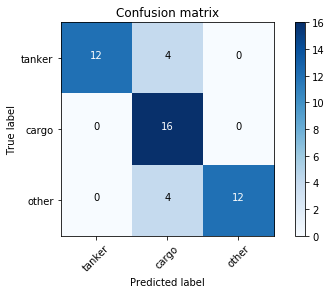

In [20]:
cm_plot_labels = types
plot_confusion_matrix(cm, cm_plot_labels,
                          title='Confusion matrix')

#plot_confusion_matrix(cm, classes=types,
#                      title='Confusion matrix, without normalization')

# Generate Classification Report

In [21]:
report = classification_report(true_label, prediction_label, target_names=types)

In [22]:
report_df = pd.DataFrame(report2dict(report)).T
report_df

,f1-score,precision,recall,support
tanker,0.86,1.00,0.75,16.0
cargo,0.80,0.67,1.00,16.0
other,0.86,1.00,0.75,16.0
avg / total,0.84,0.89,0.83,48.0


In [23]:
report_df.to_csv('classification_report.csv')

[1.0, 0.75, 0.86]
[0.67, 1.0, 0.8]
[1.0, 0.75, 0.86]
plotMat: [[1.0, 0.75, 0.86], [0.67, 1.0, 0.8], [1.0, 0.75, 0.86]]
support: [16, 16, 16]


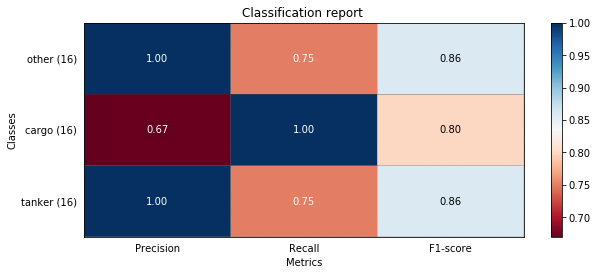

In [24]:
draw_heat_map(report)

# Visualizing the activations

In [ ]:
model.summary()

In [ ]:
# dimensions of the generated pictures for each filter.
img_width = 100
img_height = 100

# the name of the layer we want to visualize
layer_name = 'leaky_re_lu_5'

In [ ]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
# build the VGG16 network
model = test_model
print('Model loaded.')

In [ ]:
# this is the placeholder for the input images
input_img = model.input

In [ ]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [ ]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

In [ ]:
kept_filters = []
for filter_index in range(200):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

# we will stich the best 64 filters on a 8 x 8 grid.
n = 8

In [ ]:
# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        width_margin = (img_width + margin) * i
        height_margin = (img_height + margin) * j
        stitched_filters[
            width_margin: width_margin + img_width,
            height_margin: height_margin + img_height, :] = img

# save the result to disk
#save_img('stitched_filters_%dx%d.png' % (n, n), stitched_filters)

In [ ]:
figure(figsize = (20,20))
plt.imshow((stitched_filters * 255).astype(np.uint8), interpolation='nearest', aspect='auto')

In [4]:
from IPython.core.display import Image, display

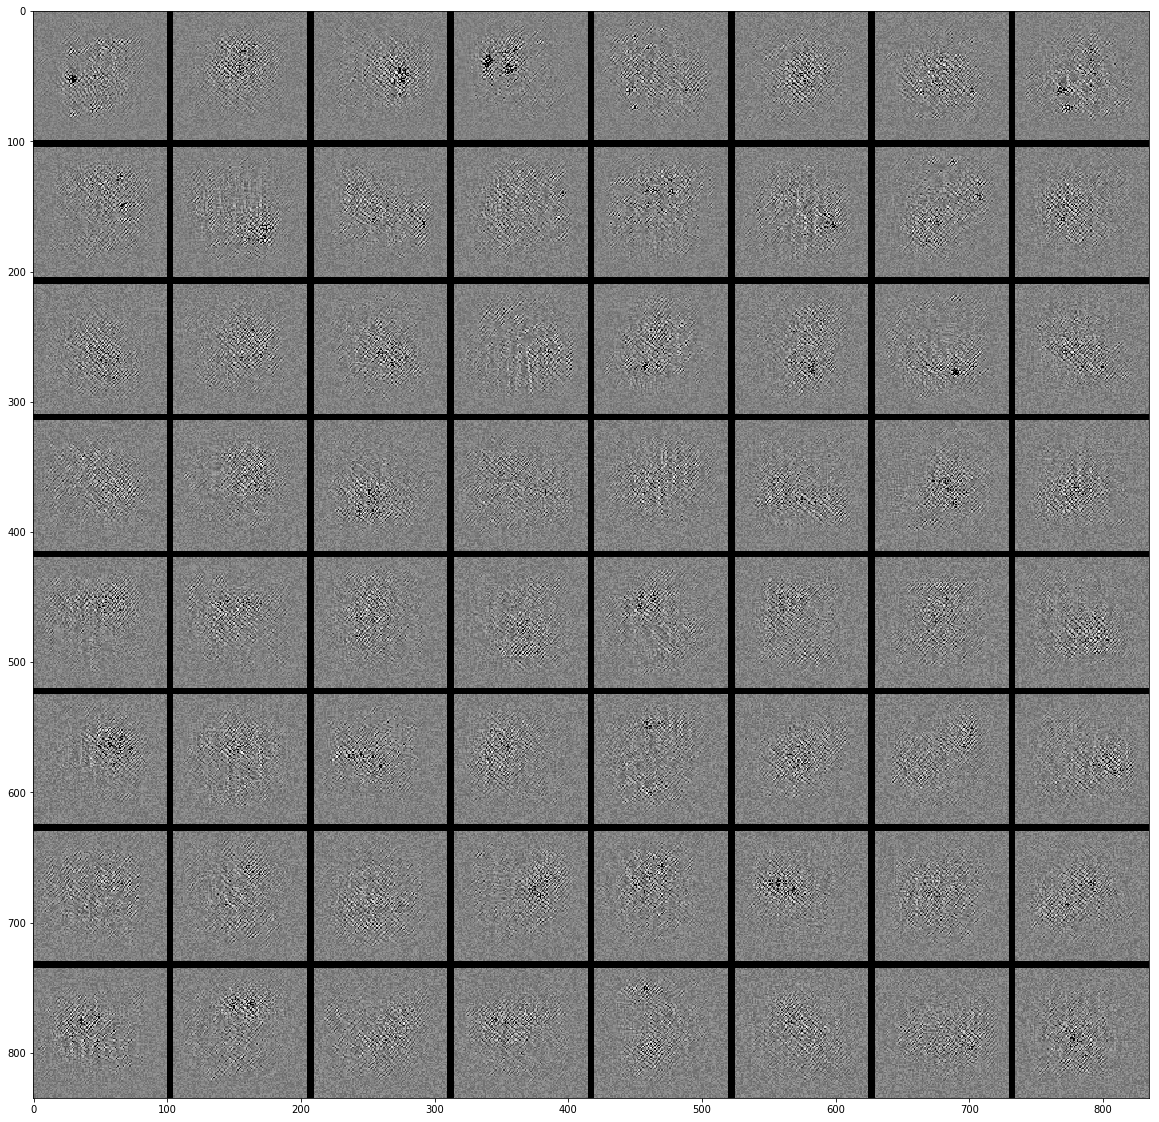

In [5]:
display(Image("Layer_visualization_256.png"))

In [26]:
model = load_model(path_to_cp_TB +'/checkpoint_2/'+'Ship_detector_3-improvement-18-0.68.hdf5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 125, 125, 16)      272       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 121, 32)      12832     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 121, 121, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        51264     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 56, 56, 64)        0         
__________